# DeepWeedX - Simple CNN Model

## Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Import Dataset

In [2]:
TRAIN_CSV = "train_set_labels.csv"
TEST_CSV = "test_set_labels.csv"
IMAGE_DIR = "dataset"

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

### Training Dataset

In [3]:
train_df

,Label,Species
0,20161207-111327-0.jpg,0
1,20170718-095159-2.jpg,0
2,20170811-133439-1.jpg,0
3,20170811-133752-1.jpg,0
4,20170217-114015-0.jpg,0
...,...,...
15002,20171205-133817-2.jpg,8
15003,20171205-141022-2.jpg,8
15004,20180322-112652-2.jpg,8
15005,20171212-100725-3.jpg,8


In [4]:
print("Total training samples:", len(train_df))
print("Class distribution:\n", train_df['Species'].value_counts())

Total training samples: 15007
Class distribution:
 Species
8    7804
0     964
6     921
1     912
4     910
2     884
3     876
7     871
5     865
Name: count, dtype: int64


### Test Dataset

In [5]:
test_df

,Label,Species
0,20160928-141107-0.jpg,0
1,20160928-141135-0.jpg,0
2,20161207-110730-0.jpg,0
3,20161207-110850-0.jpg,0
4,20161207-112015-0.jpg,0
...,...,...
2496,20180322-120255-2.jpg,8
2497,20180322-120543-2.jpg,8
2498,20180322-120934-2.jpg,8
2499,20180322-121026-2.jpg,8


In [6]:
print("Total training samples:", len(test_df))
print("Class distribution:\n", test_df['Species'].value_counts())

Total training samples: 2501
Class distribution:
 Species
8    1301
0     161
6     153
1     152
4     152
2     147
3     146
7     145
5     144
Name: count, dtype: int64


## Hyperparameters

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 9

## CNN MODEL

In [8]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype(np.float32) / 127.5 - 1
    return img

In [9]:
def create_dataset(df, image_dir):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Label'])
        images.append(load_image(img_path))
        labels.append(row['Species'])
    return np.array(images), np.array(labels)

X_train, y_train = create_dataset(train_df, IMAGE_DIR)
X_test, y_test = create_dataset(test_df, IMAGE_DIR)

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

se = layers.GlobalAveragePooling2D()(x)
se = layers.Dense(x.shape[-1] // 16, activation='relu')(se)
se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
se = layers.Reshape((1, 1, x.shape[-1]))(se)
x = layers.Multiply()([x, se])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │    102,480 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1280)      │    103,680 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│                     │ 1280)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │      1,161 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,629,785 (10.03 MB)

 Trainable params: 371,545 (1.42 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [11]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

## Training

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/50
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5263 - loss: 1.4757

376/376 ━━━━━━━━━━━━━━━━━━━━ 77s 197ms/step - accuracy: 0.5269 - loss: 1.4740 - val_accuracy: 0.7951 - val_loss: 0.7036
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.7555 - loss: 0.7216 - val_accuracy: 0.7262 - val_loss: 0.9124
Epoch 3/50
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8067 - loss: 0.5811

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.8067 - loss: 0.5812 - val_accuracy: 0.9081 - val_loss: 0.3106
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.8326 - loss: 0.4851 - val_accuracy: 0.8115 - val_loss: 0.5631
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.8562 - loss: 0.4244 - val_accuracy: 0.8518 - val_loss: 0.4411
Epoch 6/50
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8748 - loss: 0.3718

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - accuracy: 0.8748 - loss: 0.3718 - val_accuracy: 0.9334 - val_loss: 0.2405
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.8998 - loss: 0.2999 - val_accuracy: 0.8538 - val_loss: 0.4394
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9137 - loss: 0.2617 - val_accuracy: 0.8894 - val_loss: 0.3513
Epoch 9/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9220 - loss: 0.2380 - val_accuracy: 0.9131 - val_loss: 0.2963
Epoch 10/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9407 - loss: 0.1841 - val_accuracy: 0.8381 - val_loss: 0.5453
Epoch 11/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9414 - loss: 0.1663 - val_accuracy: 0.8757 - val_loss: 0.4398
Epoch 12/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9545 - loss: 0.1425 - val_accuracy: 0.8641 - val_loss: 0.4790
Epoch 13/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.9507 - loss: 0.1426 -

## Test

In [13]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
print(classification_report(y_test, y_pred))

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       161
           1       0.87      0.62      0.73       152
           2       0.88      0.79      0.83       147
           3       0.88      0.51      0.64       146
           4       0.66      0.81      0.73       152
           5       0.92      0.76      0.84       144
           6       0.87      0.57      0.69       153
           7       0.66      0.71      0.68       145
           8       0.83      0.92      0.87      1301

    accuracy                           0.81      2501
   macro avg       0.80      0.71      0.74      2501
weighted avg       0.81      0.81      0.80      2501



## Results

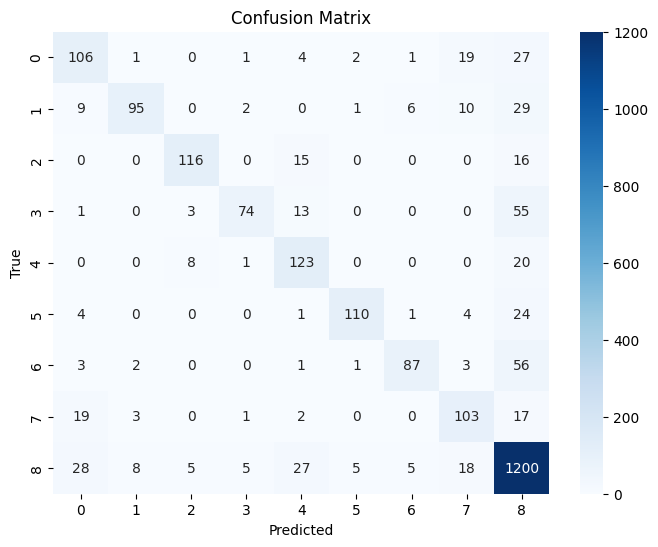

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

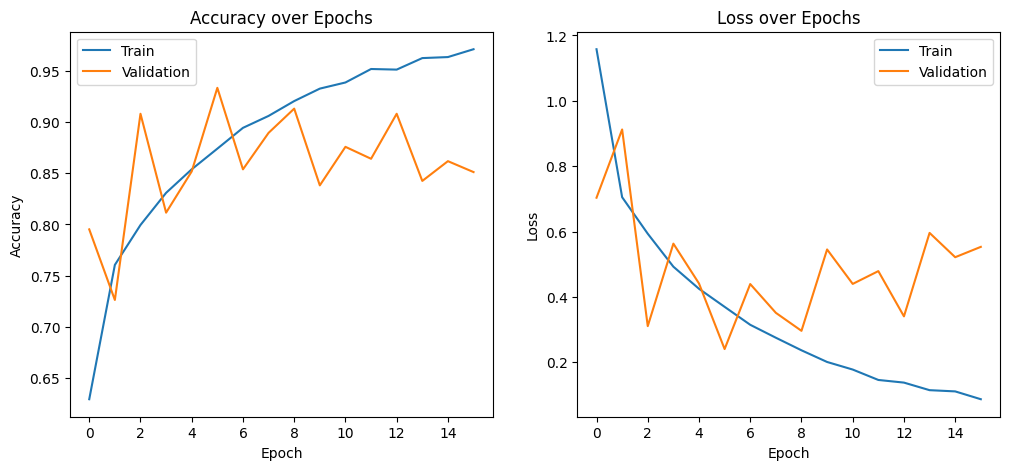

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

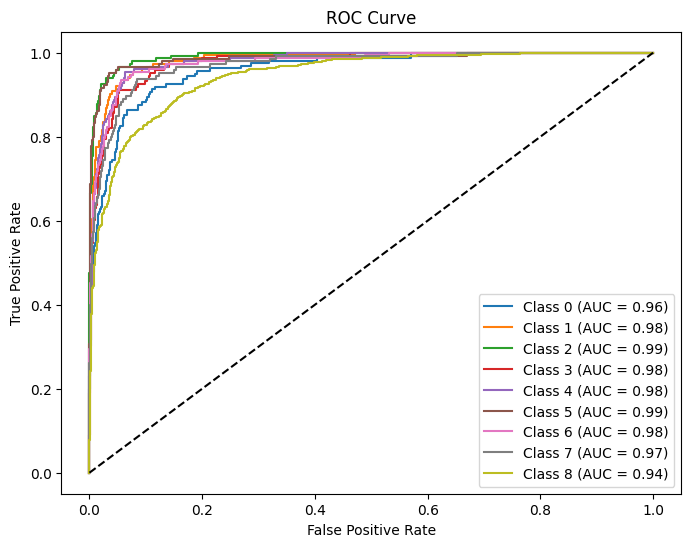

In [16]:
class_names = list(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=class_names)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

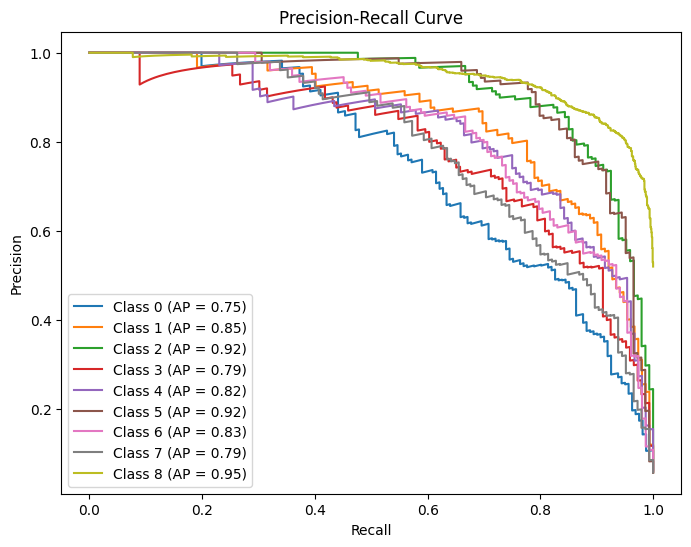

In [17]:
precision = dict()
recall = dict()
avg_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], preds[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], preds[:, i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {avg_precision[i]:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
